# DA5401 Assignment #5
## Visualizing Data Veracity Challenges in Multi-Label Classification

#### Libraries


In [1]:
pip install liac-arff

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=c3a3ffee6b7345871646af4db6d4091698370642a3411cd5a845a017eff921cd
  Stored in directory: /root/.cache/pip/wheels/a9/ac/cf/c2919807a5c623926d217c0a18eb5b457e5c19d242c3b5963a
Successfully built liac-arff


In [2]:
import os
import sys
import urllib.request
import io
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
import arff
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import xml.etree.ElementTree as ET

## Part A: Preprocessing and Initial Setup

In [4]:
ARFF_PATH = "/content/yeast.arff"
XML_PATH  = "/content/yeast.xml"

#Parse XML for label names

def parse_mulan_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    # Handles <labels xmlns="..."><label name="ClassX"/>
    labels = [elem.attrib['name'] for elem in root.findall(".//{*}label")]
    return labels

label_names = parse_mulan_xml(XML_PATH)
print("Labels from XML:", label_names)

#Load ARFF into DataFrame
with open(ARFF_PATH, 'r') as f:
    arff_data = arff.load(f)

attributes = [attr[0] for attr in arff_data['attributes']]
df = pd.DataFrame(arff_data['data'], columns=attributes)

print("Data shape:", df.shape)
print("Attributes:", len(attributes))

#Split Features vs Labels
Y_cols = label_names
X_cols = [col for col in df.columns if col not in Y_cols]

# Convert to numpy arrays
X = df[X_cols].astype(float).values
Y = df[Y_cols].astype(int).values

print("Feature matrix X:", X.shape)   # (n_samples, 103)
print("Label matrix   Y:", Y.shape)   # (n_samples, 14)

Labels from XML: ['Class1', 'Class2', 'Class3', 'Class6', 'Class4', 'Class10', 'Class11', 'Class5', 'Class7', 'Class8', 'Class9', 'Class12', 'Class13', 'Class14']
Data shape: (2417, 117)
Attributes: 117
Feature matrix X: (2417, 103)
Label matrix   Y: (2417, 14)


In [17]:
import numpy as np

label_counts = Y.sum(axis=1)
single_label_mask = label_counts == 1
multi_label_mask = label_counts > 1

# --- For single-label samples ---
single_label_data = Y[single_label_mask]  # ✅ use array slicing
single_label_classes = np.argmax(single_label_data, axis=1)  # which label is active

# Count frequency of each label among single-label samples
single_label_counts = np.bincount(single_label_classes, minlength=Y.shape[1])
top_two_single_labels = np.argsort(single_label_counts)[-2:]  # indices of top 2

# --- For multi-label samples ---
multi_label_data = Y[multi_label_mask]
unique_combos, combo_counts = np.unique(multi_label_data, axis=0, return_counts=True)
top_multi_combo = unique_combos[np.argmax(combo_counts)]  # most frequent combo

# --- Create new categorical target for visualization ---
color_labels = np.full(Y.shape[0], 'Other', dtype=object)

# Assign top single labels
for i, label_idx in enumerate(top_two_single_labels):
    mask = (Y[:, label_idx] == 1) & (label_counts == 1)
    color_labels[mask] = f'Single_Label_Top_{i+1}'

# Assign top multi-label combo
mask_multi = np.all(Y == top_multi_combo, axis=1)
color_labels[mask_multi] = 'Top_Multi_Label_Combo'

# color_labels is now ready to use for plotting
print(np.unique(color_labels, return_counts=True))


(array(['Other', 'Single_Label_Top_2', 'Top_Multi_Label_Combo'],
      dtype=object), array([2148,   32,  237]))


In [10]:
unique_labels, counts = np.unique(color_labels, return_counts=True)
print("Category counts:")
for label, count in zip(unique_labels, counts):
    print(f"{label}: {count}")

Category counts:
Other: 2148
Single_Label_Top_2: 32
Top_Multi_Label_Combo: 237


In [13]:
print("Category labels: ",unique_labels)

Category labels:  ['Other' 'Single_Label_Top_2' 'Top_Multi_Label_Combo']


###Explain why scaling is crucial before applying distance-based dimensionality reduction techniques.
Scaling is crucial for distance-based algorithms since these methods are highly affected by the magnitude of feature values. If features are left on different scales, those with larger numerical ranges can dominate the distance computations, misleading the algorithm into assigning them greater importance purely because of their scale. Standardizing or normalizing features to a common range ensures that each variable contributes equally to the analysis. This process enables the model to uncover genuine patterns in the data, without distortions introduced by inconsistent units or magnitudes.

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Original shape:", X.shape)
print("Scaled mean (first 5 features):", np.round(X_scaled.mean(axis=0)[:5], 3))
print("Scaled std  (first 5 features):", np.round(X_scaled.std(axis=0)[:5], 3))

Original shape: (2417, 103)
Scaled mean (first 5 features): [ 0. -0. -0.  0. -0.]
Scaled std  (first 5 features): [1. 1. 1. 1. 1.]


## Part B : t-SNE and Veracity Inspection

t-SNE finished for perplexity = 5
t-SNE finished for perplexity = 10
t-SNE finished for perplexity = 20
t-SNE finished for perplexity = 30
t-SNE finished for perplexity = 40
t-SNE finished for perplexity = 50
t-SNE finished for perplexity = 60
t-SNE finished for perplexity = 70
t-SNE finished for perplexity = 80
t-SNE finished for perplexity = 90
t-SNE finished for perplexity = 100
t-SNE finished for perplexity = 110


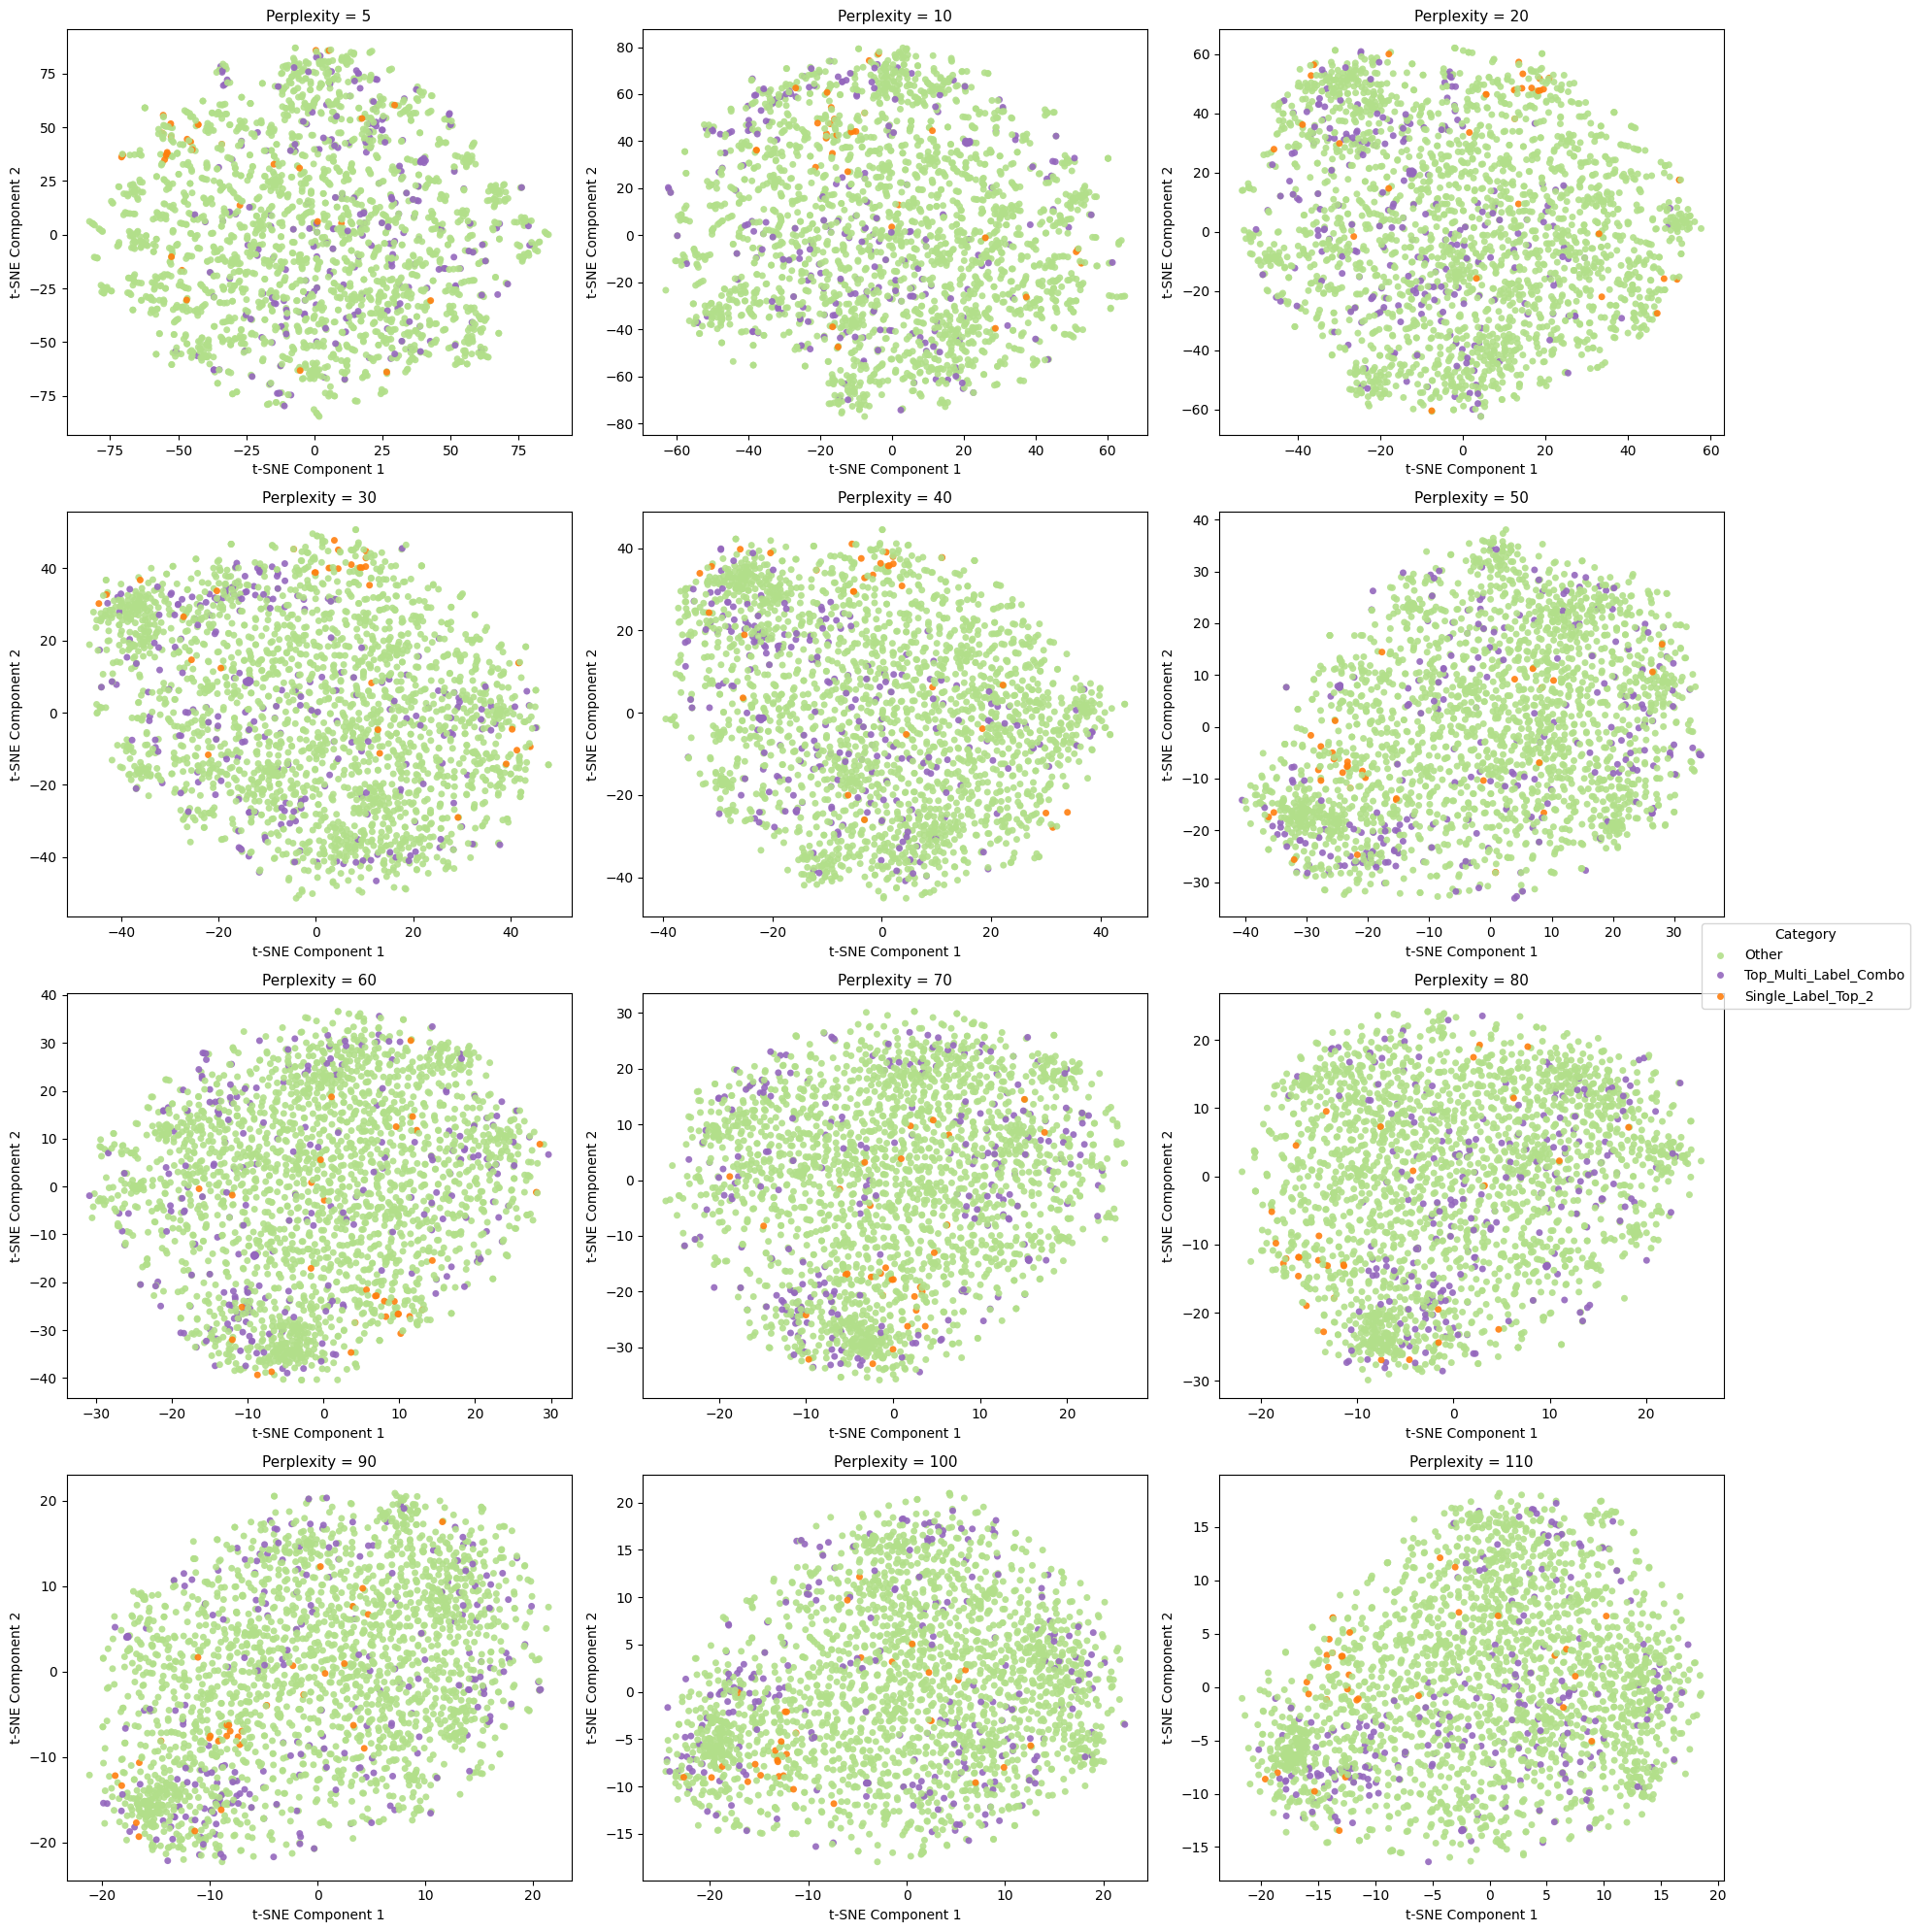

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Trying t-SNE for different perplexity values
perplexities = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
tsne_results = {}

for p in perplexities:
    tsne = TSNE(
        n_components=2,
        perplexity=p,
        learning_rate='auto',
        init='random',
        random_state=42
    )
    tsne_results[p] = tsne.fit_transform(X_scaled)
    print(f"t-SNE finished for perplexity = {p}")

# Custom color scheme for categories
palette_custom = {

    'Single_Label_Top_2': '#ff7f0e',   # orange
    'Top_Multi_Label_Combo': '#9467bd', # purple
    'Other': '#b2df8a'                 #pale green
}

# Creating a grid of subplots (3x3 for 9 perplexities)
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten()

# Drawing t-SNE scatterplots for each perplexity
for i, p in enumerate(perplexities):
    ax = axes[i]
    sns.scatterplot(
        x=tsne_results[p][:, 0],
        y=tsne_results[p][:, 1],
        hue=color_labels,
        palette=palette_custom,
        s=25,
        edgecolor='none',
        alpha=0.9,
        ax=ax
    )
    ax.set_title(f"Perplexity = {p}", fontsize=11)
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.legend_.remove()

# Add one legend for all subplots on the right
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Category", loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.tight_layout()
plt.show()


t-SNE completed for perplexity = 30


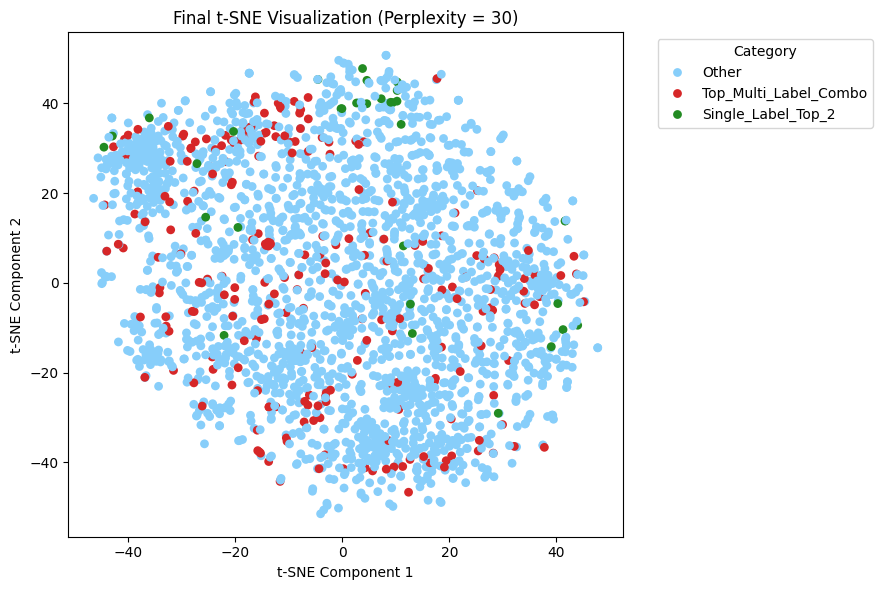

In [29]:
final_p = 30
tsne_results_f = {}
tsne_f = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='random',
    random_state=42
)
tsne_results_f[final_p] = tsne_f.fit_transform(X_scaled)
print(f"t-SNE completed for perplexity = {final_p}")
final_tsne = tsne_results_f[final_p]
palette_custom = {
    'Single_Label_Top_2': '#228B22',
    'Top_Multi_Label_Combo': '#d62728',
    'Other': '#87CEFA'
}
plt.figure(figsize=(9, 6))
sns.scatterplot(
    x=final_tsne[:, 0],
    y=final_tsne[:, 1],
    hue=color_labels,
    palette=palette_custom,
    s=40,
    edgecolor='none'
)
plt.title(f"Final t-SNE Visualization (Perplexity = {final_p})", fontsize=12)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# 1. Noisy / Ambiguous Labels
Noisy or ambiguous labels occur where points of one color are embedded within clusters of another color.  

**Observation from the plots:**  
Most clusters are fairly distinct, but a few regions show cross-color points — for instance, **orange points inside a pale green cluster**, **purple points inside a green region**, or **dark green points among light blue ones**.

In the **left-middle region**, which is mostly light blue or pale green, a few **orange or dark green points** appear misplaced — these could represent mislabeled samples or entities sharing expression patterns with both classes.  

Likewise, in the **upper-right region** (primarily orange or dark green), some **light blue points** are embedded inside the cluster.  

These patterns could arise due to annotation errors or biologically overlapping expression profiles among related functional groups.

# 2. Outliers
Outliers are isolated points or small, distant clusters separated from the main groups.  

**Observation from the plots:**  
A few isolated points can be seen in the **lower-left** and **upper-left** corners, away from dense clusters.  

There’s also a small **orange or red sub-cluster** near the top-center, slightly detached from its main group.  

A few **blue or green points** appear far from any major cluster in the **bottom-left region**.

**Possible explanations for these anomalies:**
- Rare or less-represented cell types.  
- Technical artifacts arising from sequencing or preprocessing.  
- Extreme gene expression driving these points away in t-SNE space.  
- Mixed samples (e.g., doublets/multiplets) leading to ambiguous profiles.

# 3. Hard-to-Learn Samples
Hard-to-learn samples occur where multiple colors are heavily mixed, indicating poor separability between classes.  

**Observation from the plots:**  
The **central region** (around *t-SNE Dim 1 = 0, t-SNE Dim 2 = 0*) shows dense mixing of **orange, purple, and green**, or **dark green, red, and light blue** points.  

Similarly, the **right-middle region** contains overlapping **orange and green**, or **red and blue**, with no clear cluster boundaries.

**Why simple models would struggle:**  
In these regions, expression profiles are highly similar across classes, resulting in overlapping embeddings.  
A simple classifier (like logistic regression) would fail to find clear, linear decision boundaries here.  

Such points may represent transcriptomically similar cells that differ in functional annotation or state — possibly due to shared pathways or transitional biological states.

# Summary
- **Noisy labels:** Points of one color embedded within another color’s cluster.  
- **Outliers:** Isolated points or mini-clusters distant from main groups.  
- **Hard-to-learn samples:** Mixed-color regions showing minimal separability across classes.


## Part C : Isomap and Manifold Learning

Isomap embedding shape: (2417, 2)


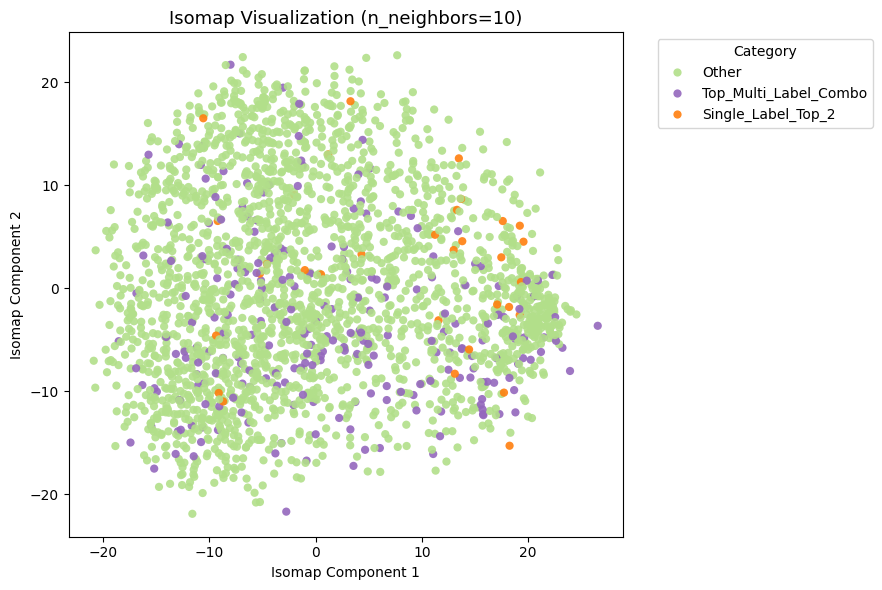

In [32]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import seaborn as sns

# --- Isomap Implementation ---
# Reduce to 2 dimensions
n_neighbors = 10  # you can tune this
isomap = Isomap(n_neighbors=n_neighbors, n_components=2)
X_isomap = isomap.fit_transform(X_scaled)

print(f"Isomap embedding shape: {X_isomap.shape}")

# --- Visualization ---
# Custom palette (same as t-SNE)
palette_custom = {

    'Single_Label_Top_2': '#ff7f0e',   # orange
    'Top_Multi_Label_Combo': '#9467bd', # purple
    'Other': '#b2df8a'                 #pale green
}

plt.figure(figsize=(9, 6))
sns.scatterplot(
    x=X_isomap[:, 0],
    y=X_isomap[:, 1],
    hue=color_labels,
    palette=palette_custom,
    s=35,
    edgecolor='none',
    alpha=0.9
)
plt.title(f"Isomap Visualization (n_neighbors={n_neighbors})", fontsize=13)
plt.xlabel("Isomap Component 1")
plt.ylabel("Isomap Component 2")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



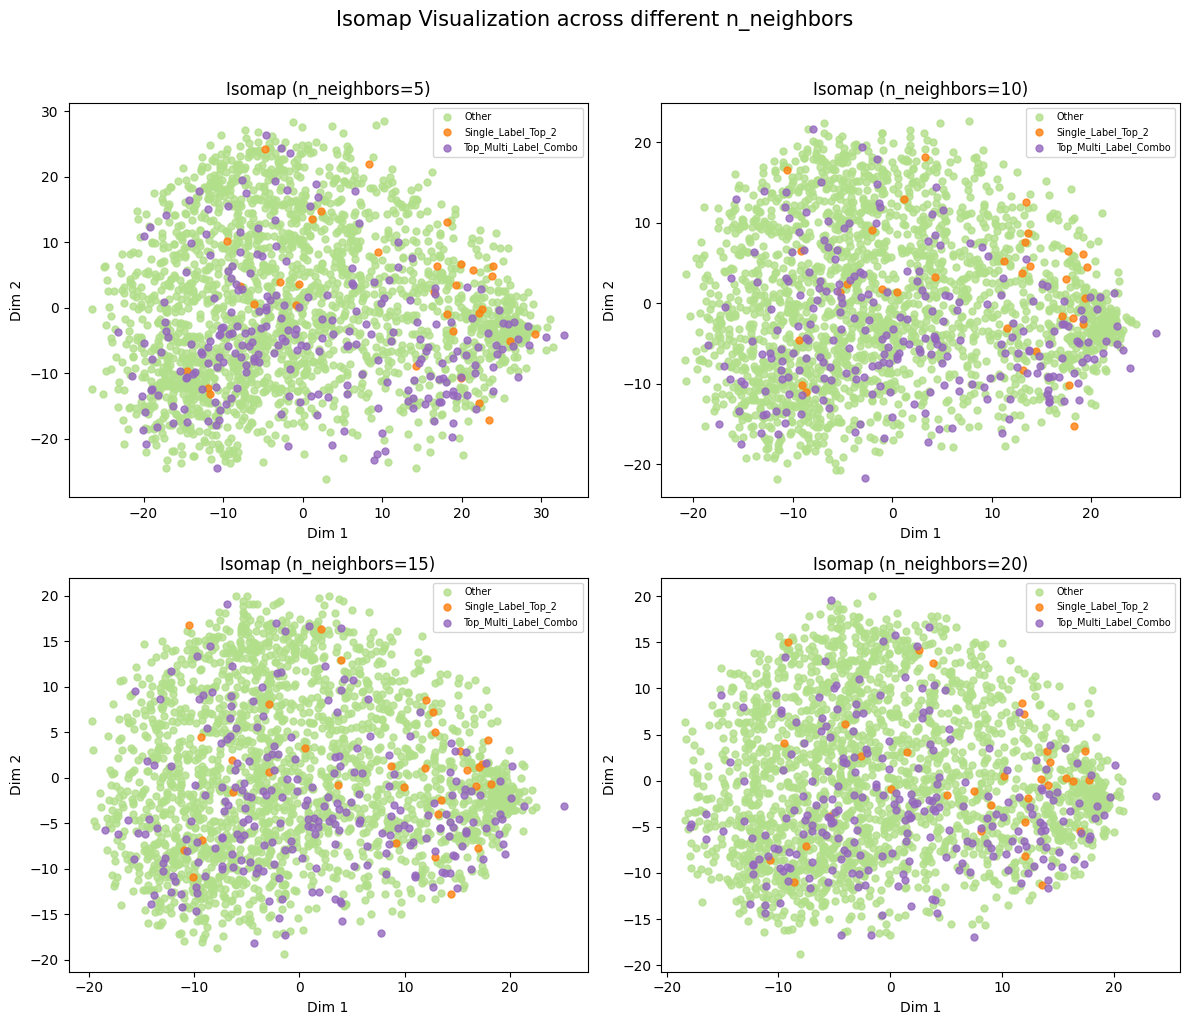

In [33]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

# --- 4 n_neighbors values ---
n_neighbors_list = [5, 10, 15, 20]

palette_custom = {

    'Single_Label_Top_2': '#ff7f0e',   # orange
    'Top_Multi_Label_Combo': '#9467bd', # purple
    'Other': '#b2df8a'                 #pale green
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, n in enumerate(n_neighbors_list):
    Z_tmp = Isomap(n_neighbors=n, n_components=2).fit_transform(X_scaled)
    ax = axes[i]
    for cat in np.unique(color_labels):
        idx = color_labels == cat
        ax.scatter(Z_tmp[idx, 0], Z_tmp[idx, 1],
                   s=25, alpha=0.8, label=cat, c=palette_custom[cat])
    ax.set_title(f"Isomap (n_neighbors={n})", fontsize=12)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.legend(fontsize="x-small")

plt.suptitle("Isomap Visualization across different n_neighbors", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()


## 3. Comparison and Curvature Analysis

### Comparison: Isomap vs t-SNE Visualization

**Isomap Provides Better Global Structural Insights**

A comparison between the two manifold learning methods reveals the following:

| Aspect | Isomap | t-SNE |
|:-------|:--------|:------|
| **Global Structure** |  **Strong** — Retains overall manifold geometry |  **Weak** — Emphasizes only local neighborhoods |
| **Cluster Separation** |  **Distinct** — Clearly divided and well-spaced clusters |  **Partial** — Some mixing between clusters |
| **Distance Preservation** |  **Geodesic distances** maintained across data manifold |  **Local distances** preserved; global structure distorted |
| **Outlier Detection** |  **Straightforward** — Distant points remain separated |  **Limited** — Compression hides some outliers |

**Observations:**
- Isomap clearly displays **three large, spatially distinct clusters**.
- It effectively retains **inter-cluster relationships**, showing which groups are closer or farther.
- The **Top_Multi_Label_Combo** cluster appears compact and well-defined.
- The **Single_Label_Top_2** and **Other** groups exhibit more internal diversity and overlap.
- In contrast, t-SNE prioritizes **local cohesion**, often breaking global continuity to emphasize fine details.

**Inference:**  
Isomap provides a clearer picture of the **global manifold geometry** and relationships between data categories, making it more suitable for understanding the overall data topology than t-SNE.

### Data Manifold Analysis

#### Manifold Complexity and Curvature

**The Isomap embedding indicates a moderately curved manifold** — structured but not extremely complex.

**Indicators of Moderate Curvature:**
1. **Non-linear Grouping:** Data clusters are non-spherical and separated by curved boundaries.  
2. **Multiple Regions of Connectivity:** Roughly 2–3 main manifolds with varying densities.  
3. **Density Variation:** Some clusters are denser than others, showing local curvature changes.  
4. **Irregular Boundaries:** Cluster edges are not smooth, suggesting intrinsic geometric complexity.

**Indicators of Manageable Complexity:**
- Clusters are relatively compact and distinct.  
- The manifold does not exhibit extreme twists or “rolled” geometry.  
- Global structure remains interpretable.


#### Implications for Classification

**Expected Classification Difficulty: Moderate**

1. **Good Separation → Simpler Decisions:**  
   - Major clusters (e.g., *Top_Multi_Label_Combo*) are well-isolated.  
   - Suggests the existence of **strong discriminative features**.

2. **Curved Boundaries → Non-linear Models Required:**  
   - Non-spherical cluster shapes imply **non-linear decision boundaries**.  
   - **Kernel SVMs, tree ensembles, or neural networks** would perform better than linear models.

3. **Mixed Regions → Uncertain Predictions:**  
   - Partial overlap between **Single_Label_Top_2** and **Other** indicates **ambiguous regions**.  
   - These correspond to samples with shared gene expression traits across categories.  
   - Classification confidence will vary depending on local manifold density.

### Manifold Learning Insights

- The data lies on a **moderately curved, interpretable manifold**, validating the use of **non-linear dimensionality reduction** techniques like Isomap or t-SNE.  
- Cluster organization appears biologically meaningful, suggesting intrinsic relationships among functional categories.  
- Simple models may **underfit**, while overly complex ones might **overfit** due to local variations.

**Recommended Approaches:**
- **Tree-based ensembles (e.g., Random Forest, XGBoost)** or **kernel-based methods** for balanced performance.  
- **Deep learning** models could be used for large-scale datasets but are unnecessary for smaller ones.  
- **Ensemble techniques** offer robustness to local manifold curvature differences.
